*Reference*<br>
https://www.youtube.com/watch?v=WgsZc_wS2qQ

In [ ]:
import torch
import torchvision
from torchvision import models
import torchvision.transforms as T

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

print('pytorch', torch.__version__)
print('torchvision', torchvision.__version__)

pytorch 1.5.1+cu101
torchvision 0.6.1+cu101


In [ ]:
IMG_SIZE = 480
THRESHOLD = 0.95

# Download Model

https://pytorch.org/docs/stable/torchvision/models.html

In [ ]:
model = models.detection.keypointrcnn_resnet50_fpn(pretrained=True).eval()

Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


# Load Image

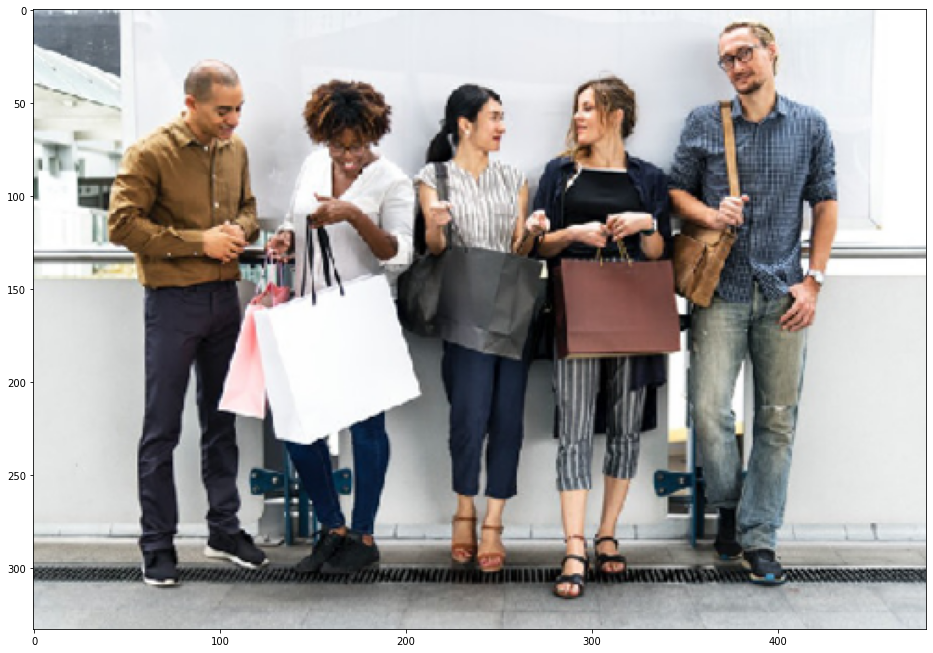

In [ ]:
img = Image.open('07.jpg')
img = img.resize((IMG_SIZE, int(img.height * IMG_SIZE / img.width)))

plt.figure(figsize=(16, 16))
plt.imshow(img)

# Image to Tensor
* T.ToTensor() : Converts the image to type torch.Tensor and have values between [0, 1]

In [ ]:
trf = T.Compose([
    T.ToTensor()
])

input_img = trf(img)

print(input_img.shape)

torch.Size([3, 333, 480])


# Inference
* boxes (Tensor[N, 4]): the ground-truth boxes in [x0, y0, x1, y1] format, with values between 0 and H and 0 and W
* labels (Tensor[N]): the class label for each ground-truth box
* keypoints (Tensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible.

In [ ]:
out = model([input_img])[0]

# boxes: 사람의 bounding box 영역(x0, y0, x1, y1)
# scores: bounding box를 사람이라고 판단한 점수, 높을수록 사람일 확률이 높음
# keypoints: 사람의 keypoint의 좌표
print(out.keys())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])


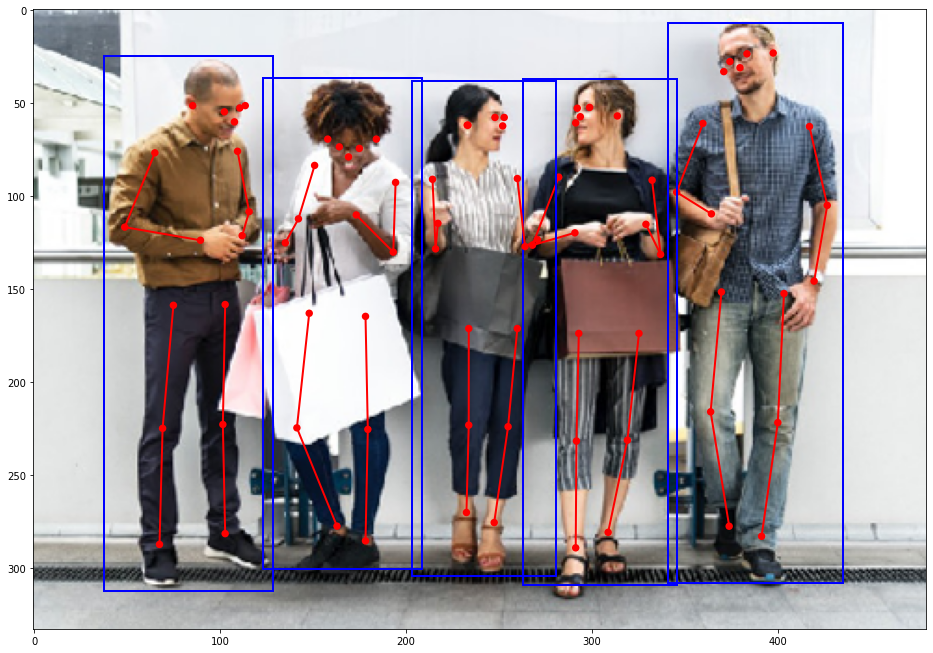

In [ ]:
codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO
]

fig, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(img)

for box, score, keypoints in zip(out['boxes'], out['scores'], out['keypoints']):
    # tensor.detach(): 그래프에서 텐서를 분리한다.
    # tensor.numpy(): 텐서를 numpy 배열로 변환한다.
    score = score.detach().numpy()

    if score < THRESHOLD:
        continue

    box = box.detach().numpy()
    # keypoints (Tensor[N, K, 3]): the K keypoints location for each of the N instances,
    # in the format [x, y, visibility],
    # where visibility=0 means that the keypoint is not visible.
    # N: 사람일 가능성이 있는 bounding box의 개수
    # K: 키포인트의 개수
    # visibility=0: 키포인트가 몸이나 사물에 가려서 안보이는 경우
    keypoints = keypoints.detach().numpy()[:, :2]

    # patches.Rectangle((x0, y0), w, h)
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)

    # 17 keypoints
    for k in keypoints:
        circle = patches.Circle((k[0], k[1]), radius=2, facecolor='r')
        ax.add_patch(circle)
    
    # draw path
    # left arm
    path = Path(keypoints[5:10:2], codes)
    line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='r')
    ax.add_patch(line)
    
    # right arm
    path = Path(keypoints[6:11:2], codes)
    line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='r')
    ax.add_patch(line)
    
    # left leg
    path = Path(keypoints[11:16:2], codes)
    line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='r')
    ax.add_patch(line)
    
    # right leg
    path = Path(keypoints[12:17:2], codes)
    line = patches.PathPatch(path, linewidth=2, facecolor='none', edgecolor='r')
    ax.add_patch(line)